In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import thop
import torch
import torch.quantization

from src.augmentations import DefaultWave2Spec
from src.configs import DefaultConfig
from src.data_utils import get_dataloaders, SpeechCommandsDataset
from src.models import CRNN
from src.trainers import DefaultTrainer
from src.utils import count_parameters, get_size_in_megabytes, seed_all

In [3]:
CHECKPOINT_DIR = Path('checkpoints')
DATA_DIR = Path('data/speech_commands')
TRAIN_CSV = Path('data/train.csv')
VAL_CSV = Path('data/val.csv')

Для начала давайте загрузим все модели и посмотрим, какое у них качество на валидации:

In [4]:
baseline, distillated_hs32, distillated_hs16, distillated_hs16_c4 = {}, {}, {}, {}

In [5]:
CONFIG = 'config'
MACS = 'macs'
METRIC = 'metric'
MODEL = 'model'
NAME = 'name'
NUM_PARAMS = 'num_params'
QUANTIZED = 'quantized'
QUANTIZED_METRIC = 'qmetric'
QUANTIZED_SIZE = 'qsize'
QUANTIZED_TIME = 'qtime'
SIZE = 'size'
TIME = 'time'

In [6]:
baseline[CONFIG] = DefaultConfig()

distillated_hs32[CONFIG] = DefaultConfig(hidden_size=32)

distillated_hs16[CONFIG] = DefaultConfig(hidden_size=16)

distillated_hs16_c4[CONFIG] = DefaultConfig(
    hidden_size=16,
    cnn_out_channels=4,
    stride=(5, 10),
    kernel_size=(10, 20)
)

In [7]:
for d, p in zip(
    (baseline, distillated_hs32, distillated_hs16, distillated_hs16_c4),
    ('baseline', 'distillated_hs32', 'distillated_hs16', 'distillated_hs16_c4')
):
    d[MODEL] = CRNN(d[CONFIG])
    d[MODEL].load_state_dict(
        torch.load(CHECKPOINT_DIR / f'{p}.pth', map_location=d[CONFIG].device)
    )
    d[NAME] = p

In [8]:
val_ds = SpeechCommandsDataset(DATA_DIR, csv=pd.read_csv(VAL_CSV))

In [9]:
for d in (baseline, distillated_hs32, distillated_hs16, distillated_hs16_c4):
    seed_all()
    _, val_loader = get_dataloaders(None, val_ds, d[CONFIG].batch_size)
    val_wave2spec = DefaultWave2Spec(is_train=False, config=d[CONFIG])
    trainer = DefaultTrainer(
        opt=None,
        train_loader=None,
        val_loader=val_loader,
        device=d[CONFIG].device,
        model=d[MODEL],
        train_wave2spec=None,
        val_wave2spec=val_wave2spec,
    )
    d[METRIC] = trainer.validation()
    print(f'{d[NAME]} validation au_fa_fr: {d[METRIC]}')

100%|██████████| 102/102 [01:05<00:00,  1.55it/s]


baseline validation au_fa_fr: 1.63451128246924e-05


100%|██████████| 102/102 [00:33<00:00,  3.07it/s]


distillated_hs32 validation au_fa_fr: 2.4789192651979638e-05


100%|██████████| 102/102 [00:34<00:00,  2.93it/s]


distillated_hs16 validation au_fa_fr: 4.942322906685011e-05


100%|██████████| 102/102 [00:32<00:00,  3.15it/s]


distillated_hs16_c4 validation au_fa_fr: 4.683928096422441e-05


Мы видим, что все модели удовлетворяют нашему порогу качества. Довольно интересно, что самая маленькая модель `distillated_hs16_c4` показывает себя лучше, чем `distillated_hs16`. Я думаю, это связано с тем, что изменение параметров `kernel_size` и `stride` повлияло на качество модели в лучшую сторону. Теперь давайте для каждой модели посчитаем интересующие нас характеристики и нарисуем графики:

In [10]:
for d in (baseline, distillated_hs32, distillated_hs16, distillated_hs16_c4):
    d[MACS], d[NUM_PARAMS] = thop.profile(
        d[MODEL], (torch.randn(1, DefaultConfig.n_mels, 100),), verbose=False
    )
    d[SIZE] = get_size_in_megabytes(d[MODEL])
    print(d[NAME], d[MACS], d[NUM_PARAMS], d[SIZE])

print(f'speedup rate: {baseline[MACS] / distillated_hs16_c4[MACS]}')
print(f'compression rate: {baseline[SIZE] / distillated_hs16_c4[SIZE]}')

baseline 933808.0 70443.0 0.2687187194824219
distillated_hs32 434256.0 25387.0 0.09684371948242188
distillated_hs16 268960.0 10539.0 0.040203094482421875
distillated_hs16_c4 89708.0 4967.0 0.018947601318359375
speedup rate: 10.409417220314799
compression rate: 14.182202536742501


Для того, чтобы замерить `MACs` я подавал на вход тензор размерности (1, 40, 100). Мы хотим исследовать скорость inference-a, поэтому логично использовать размер батча, равный единице. Такой тензор соответствует спектрограмме аудиозаписи длины примерно 1 секунда, в нашей выборке большинство аудио имеет как раз такую продолжительность. Видно, что при таких условиях эксперимента, самая маленькая модель больше чем в 10 раз уменьшает время выполнения и используемую память. Но можно подать на вход тензор побольше и убедиться, что и в этом случае соотношение скоростей останется таким же:

In [11]:
baseline_macs, _ = thop.profile(
    baseline[MODEL], (torch.randn(1024, DefaultConfig.n_mels, 1024),), verbose=False
)
distillated_hs16_c4_macs, _ = thop.profile(
    distillated_hs16_c4[MODEL], (torch.randn(1024, DefaultConfig.n_mels, 1024),), verbose=False
)
print(f'speedup rate: {baseline_macs / distillated_hs16_c4_macs}')

speedup rate: 10.627037468352418


Теперь построим графики:

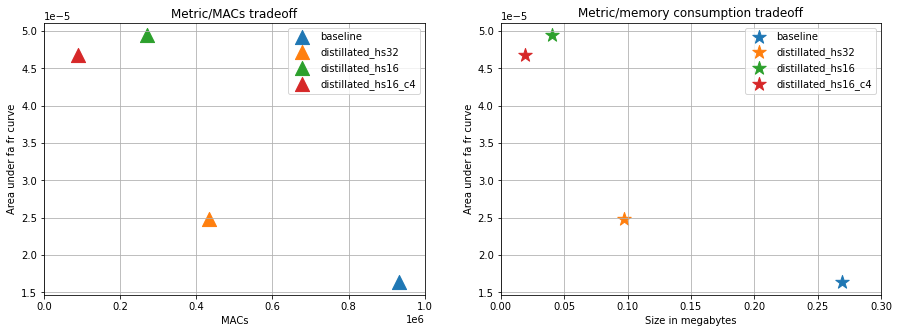

In [36]:
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for d in (baseline, distillated_hs32, distillated_hs16, distillated_hs16_c4):
    ax1.scatter([d[MACS]], [d[METRIC]], s=200, marker='^', label=d[NAME])
    ax1.grid(visible=True)
    ax1.set_xlabel('MACs')
    ax1.set_xlim((0, 1_000_000))
    ax1.set_ylabel('Area under fa fr curve')
    ax1.legend()
    ax1.set_title('Metric/MACs tradeoff')

    ax2.scatter([d[SIZE]], [d[METRIC]], s=200, marker='*', label=d[NAME])
    ax2.grid(visible=True)
    ax2.set_xlabel('Size in megabytes')
    ax2.set_xlim((0, 0.3))
    ax2.set_ylabel('Area under fa fr curve')
    ax2.legend()
    ax2.set_title('Metric/memory consumption tradeoff')

Мы видим, что время и память ведут себя похожим образом в зависимости от модели. Из графиков очевидно, что `distillated_hs16` показывает себя хуже остальных моделей, потому что `distillated_hs16_c4` опережает ее во всем. Если забыть про эту модель, то каждая из 3 оставшихся моделей может быть полезна в тех или иных условиях, в зависимости от ограничений по памяти и времени.

Теперь квантизуем модели. Делать это я буду следующим образом: просто применю dynamic quantization ко всем слоям, кроме сверточного, потому что он не поддерживает такой вид квантизации.

In [13]:
for d in (baseline, distillated_hs32, distillated_hs16, distillated_hs16_c4):
    d[QUANTIZED] = torch.quantization.quantize_dynamic(
        d[MODEL], {torch.nn.GRU, torch.nn.Linear}, dtype=torch.qint8)

    seed_all()
    _, val_loader = get_dataloaders(None, val_ds, d[CONFIG].batch_size)
    val_wave2spec = DefaultWave2Spec(is_train=False, config=d[CONFIG])
    trainer = DefaultTrainer(
        opt=None,
        train_loader=None,
        val_loader=val_loader,
        device=d[CONFIG].device,
        model=d[QUANTIZED],
        train_wave2spec=None,
        val_wave2spec=val_wave2spec,
    )
    d[QUANTIZED_METRIC] = trainer.validation()
    print(f'{d[NAME]} quantized validation au_fa_fr: {d[QUANTIZED_METRIC]}')

100%|██████████| 102/102 [00:29<00:00,  3.47it/s]


baseline quantized validation au_fa_fr: 1.7061218534427006e-05


100%|██████████| 102/102 [00:29<00:00,  3.46it/s]


distillated_hs32 quantized validation au_fa_fr: 2.5606746670593314e-05


100%|██████████| 102/102 [00:30<00:00,  3.36it/s]


distillated_hs16 quantized validation au_fa_fr: 5.209669038319264e-05


100%|██████████| 102/102 [00:30<00:00,  3.40it/s]


distillated_hs16_c4 quantized validation au_fa_fr: 4.893389016519814e-05


Мы видим, что качество на валидации у квантизованных моделей стало похуже, но они все равно проходят наш порог. Теперь построим график, где будет видно потребление памяти каждой квантизованной модели.

Для квантизованных моделей я считаю размер модели следующим образом: просто у квантизованных слоев делю размер на 4, потому что мы квантизовали из `float32` в `qint8`.

In [14]:
print(baseline[QUANTIZED])

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): DynamicQuantizedGRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): DynamicQuantizedLinear(in_features=64, out_features=64, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
      (1): Tanh()
      (2): DynamicQuantizedLinear(in_features=64, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    )
  )
  (classifier): DynamicQuantizedLinear(in_features=64, out_features=2, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)


In [15]:
for d in (baseline, distillated_hs32, distillated_hs16, distillated_hs16_c4):
    m = d[MODEL]
    d[QUANTIZED_SIZE] = get_size_in_megabytes(m.conv) + \
        get_size_in_megabytes(m.gru) / 4 + \
        get_size_in_megabytes(m.attention) / 4 + \
        get_size_in_megabytes(m.classifier) / 4

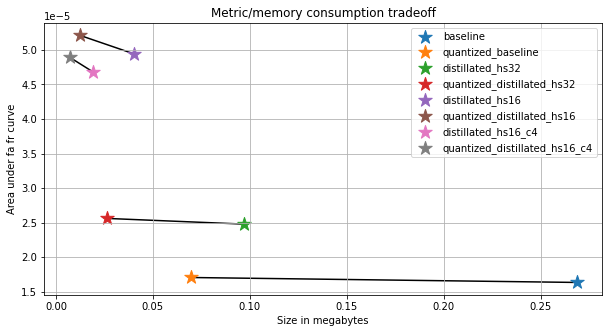

In [16]:
plt.figure(figsize=(10, 5))
for d in (baseline, distillated_hs32, distillated_hs16, distillated_hs16_c4):
    plt.scatter([d[SIZE]], [d[METRIC]], s=200, marker='*', label=d[NAME])
    plt.scatter([d[QUANTIZED_SIZE]], [d[QUANTIZED_METRIC]], s=200, marker='*', label=f'quantized_{d[NAME]}')
    plt.plot(
        [d[SIZE], d[QUANTIZED_SIZE]],
        [d[METRIC], d[QUANTIZED_METRIC]],
        c='black',
        zorder=-10
    )
    plt.grid(visible=True)
    plt.xlabel('Size in megabytes')
    plt.ylabel('Area under fa fr curve')
    plt.title('Metric/memory consumption tradeoff')
    plt.legend()

Мы видим, что для больших моделей квантизация очень существенно уменьшает потребляемую память, при этом качество ухудшается несильно.
Для маленьких моделей уже нельзя сказать, что не имеет смысла использовать неквантизованную модель, потому что качество ухудшается ощутимо.

Теперь проверим, насколько квантизация улучшает производительность.
Сделать это не так просто, потому что `thop` не умеет профилировать квантизованные модели.
Но можно сравнить их эмпирически, посмотрев, насколько быстро они работают у меня локально.
Отмечу, что это не самый лучший способ проводить такое сравнение, потому что результаты зависят от конкретного процессора, но все же это лучше, чем ничего.

In [40]:
for d in (baseline, distillated_hs32, distillated_hs16, distillated_hs16_c4):
    t = %timeit -o d[MODEL](torch.randn(1, 40, 100))
    d[TIME] = t.average

    t = %timeit -o d[QUANTIZED](torch.randn(1, 40, 100))
    d[QUANTIZED_TIME] = t.average

2.06 ms ± 94.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.43 ms ± 14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.89 ms ± 22.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.44 ms ± 45.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.86 ms ± 8.55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.4 ms ± 18.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.62 ms ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.29 ms ± 15.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


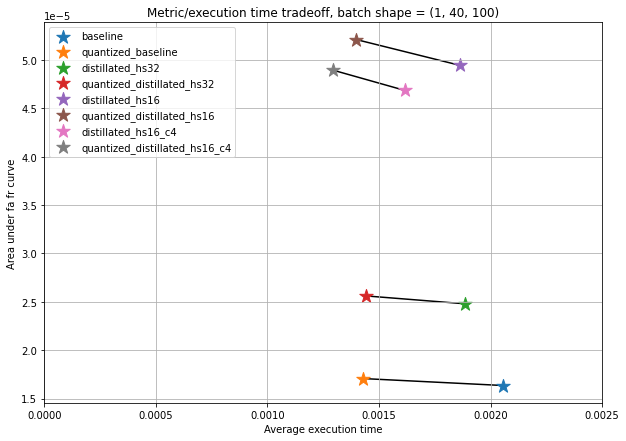

In [41]:
plt.figure(figsize=(10, 7))
for d in (baseline, distillated_hs32, distillated_hs16, distillated_hs16_c4):
    plt.scatter([d[TIME]], [d[METRIC]], s=200, marker='*', label=d[NAME])
    plt.scatter([d[QUANTIZED_TIME]], [d[QUANTIZED_METRIC]], s=200, marker='*', label=f'quantized_{d[NAME]}')
    plt.plot(
        [d[TIME], d[QUANTIZED_TIME]],
        [d[METRIC], d[QUANTIZED_METRIC]],
        c='black',
        zorder=-10
    )
    plt.grid(visible=True)
    plt.xlabel('Average execution time')
    plt.xlim((0, 0.0025))
    plt.ylabel('Area under fa fr curve')
    plt.title('Metric/execution time tradeoff, batch shape = (1, 40, 100)')
    plt.legend()

Здесь мы наблюдаем очень интересную ситуацию: квантизация дает небольшое улучшение для каждой из моделей, но при этом модели между собой отличаются не особо сильно. Скорее всего это связано с тем, что на вход подавался очень маленький тензор. Я пытался таким образом приблизить ситуацию, когда во время inference-a нам поступает на вход одна аудиозапись длительностью 1 секунда, как в нашей выборке. Но давайте интереса ради попробуем подать на вход тензор размером побольше:

In [42]:
for d in (baseline, distillated_hs32, distillated_hs16, distillated_hs16_c4):
    t = %timeit -o d[MODEL](torch.randn(1000, 40, 1000))
    d[TIME] = t.average

    t = %timeit -o d[QUANTIZED](torch.randn(1000, 40, 1000))
    d[QUANTIZED_TIME] = t.average

675 ms ± 30.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
635 ms ± 23.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
571 ms ± 40.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
527 ms ± 7.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
467 ms ± 5.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
453 ms ± 4.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
349 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
326 ms ± 4.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


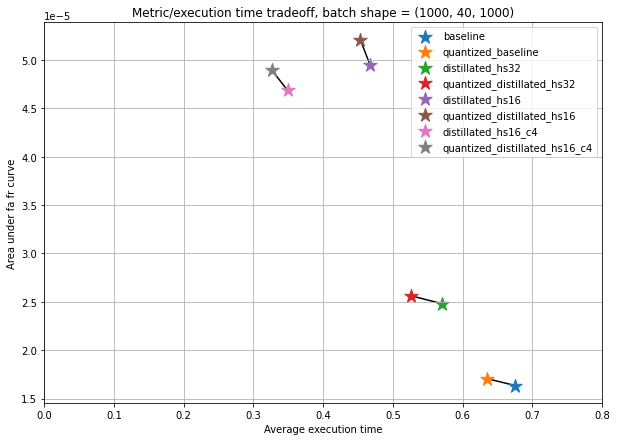

In [43]:
plt.figure(figsize=(10, 7))
for d in (baseline, distillated_hs32, distillated_hs16, distillated_hs16_c4):
    plt.scatter([d[TIME]], [d[METRIC]], s=200, marker='*', label=d[NAME])
    plt.scatter([d[QUANTIZED_TIME]], [d[QUANTIZED_METRIC]], s=200, marker='*', label=f'quantized_{d[NAME]}')
    plt.plot(
        [d[TIME], d[QUANTIZED_TIME]],
        [d[METRIC], d[QUANTIZED_METRIC]],
        c='black',
        zorder=-10
    )
    plt.grid(visible=True)
    plt.xlabel('Average execution time')
    plt.xlim(0, 0.8)
    plt.ylabel('Area under fa fr curve')
    plt.title('Metric/execution time tradeoff, batch shape = (1000, 40, 1000)')
    plt.legend()

При таких условиях эксперимента модели между собой отличаются уже посильнее, но такой же разницы, как в MACs, между ними не наблюдается. Возможно, MACs --- не очень репрезентативная метрика, если дело идет о вычислении на процессоре. Но мы все же видим, что квантизация дает небольшой прирост производительности.

Теперь давайте еще раз посмотрим, во сколько раз самая маленькая модель улучшает потребление памяти и производительность. Будем считать, что у квантизованной модели MACs такой же, как и у обычной.

In [37]:
print(f'speedup rate: {baseline[MACS] / distillated_hs16_c4[MACS]}')
print(f'compression rate: {baseline[SIZE] / distillated_hs16_c4[QUANTIZED_SIZE]}')

speedup rate: 10.409417220314799
compression rate: 38.18566201382301
